In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection as mod
import seaborn as sns

from sklearn import datasets as dat
from sklearn import tree
from sklearn import metrics as met 
from sklearn import linear_model as lin
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import ensemble as ens
from tensorflow.keras.datasets import mnist
from imblearn import under_sampling as und
from imblearn import over_sampling as over
from imblearn import pipeline as imb
from imblearn import combine as com


In [2]:
data = dat.fetch_openml("mnist_784")
#(X_train,y_train),(X_test,y_test) = mnist.load_data()  You can get the data also in this way.
X = data.data
y = data.target

In [4]:
X_train,X_test,y_train,y_test = mod.train_test_split(X,y,test_size = 0.15 , random_state = 42)

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [ ]:
# IMBALANCE LEARNING:

# If there is imbalanced data, accuracy may not be a good method. instead, f1 score, auc score etc. are looked at.

# Algorithms generally tend to predict the majority class if there is unbalanced data.

# Resampling :
     # Undersampling : Remove records from majority class
         # RandomUnderSampler,TomekLinks
     # Oversampling : Duplicates records from minority class
         #RandomOverSampler
    

In [ ]:
# RandomUnderSampler:
     # You are deleting random data from the majority class until there is a certain rate. We don't want to lose too much more.
     # We usually use it when we have a lot of data.

In [6]:
pd.Series(y_train_5).value_counts().min() / pd.Series(y_train_5).value_counts().max() # imbalanced data


0.09865760658825268

In [12]:
#stratifiedkfold : kfold splits data randomly into folds. class distributions may not be the same. but stratified kfold
# while dividing into different folds, the class distribution within each fold is tried to converge to that of all data distributions. more reliable.

skf = mod.StratifiedKFold(n_splits = 3,random_state = 42,shuffle= True)

In [27]:
pipe_sgd = imb.Pipeline([
     ("scaler",pre.StandardScaler()),
     ("undersampler",und.RandomUnderSampler(sampling_strategy = 0.25,random_state = 42)), #samplingstrategy : minority class count / majority class count after resampling
     ("sgd_clf",lin.SGDClassifier(random_state = 42))])

In [28]:
pipe_sgd.fit(X_train,y_train_5)

Pipeline(steps=[('scaler', StandardScaler()),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.25)),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [30]:
skf = mod.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)   
mod.cross_val_score(pipe_sgd,X_train,y_train_5,cv=skf,scoring = "f1").mean()

C:\Users\ugury\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.8077093908313767

In [31]:
y_pred = mod.cross_val_predict(pipe_sgd,X_train,y_train_5,cv = skf)
print("f1 score:",met.f1_score(y_train_5,y_pred))

C:\Users\ugury\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


f1 score: 0.8076647564469913


In [32]:
params = {
     "undersampler__sampling_strategy":[0.15,0.25,0.5],
     "sgd_clf__alpha": [0.0001, 0.001,0.01,0.1]
     }


In [34]:
grid = mod.GridSearchCV(pipe_sgd,params,scoring = "f1",cv = skf,n_jobs = -1)
grid.fit(X_train,y_train_5)

AttributeError: 'GridSearchCV' object has no attribute 'best_score__'

In [36]:
print(grid.best_score_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print(met.f1_score(y_test_5,y_pred))

0.8263877419801794
{'sgd_clf__alpha': 0.0001, 'undersampler__sampling_strategy': 0.15}
0.8305263157894737


In [ ]:
# RandomOverSampler can cause overfitting.
# TomekLinks : An undersampling method. Checks all the points in the data, finds the closest point to that point, each of these points has to be closest ones to each other. 
# These are called as tomeklinks. Also these two points should belong to different classes. Finding tomeklikns and deleting the one belonging to majority class or deleting both of them. It can be used as a data cleaning technique.  
# Classlar arasındaki overlap'i azaltmak için clustering de. Oran vermiyoruz burda. Çok çıkmıyor zaten.

In [39]:
sampler = und.TomekLinks() #does not delete from minority class. You have to scale the data since you are using a distance metric.


In [40]:
sampler

TomekLinks()

In [ ]:
# SMOTE : An oversampling method and it is the most used one. Synthetic Minority Oversampling Technique.
# k_neighbors = 5. Chooses a random point from the minority class  and finds the closest k neighbors to that point, determines the center point of these k closest points and produces a new point to the data. It finds the closest points with knn and therefore it can work slower compared to others.


In [41]:
pipe_sgd = imb.Pipeline([
     ("scaler",pre.StandardScaler()),
     ("smote",over.SMOTE(sampling_strategy = 0.25,random_state = 42,k_neighbors = 5)), 
     ("sgd_clf",lin.SGDClassifier(random_state = 42))])


In [42]:
pipe_sgd.fit(X_train,y_train_5)

Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.25)),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [43]:
mod.cross_val_score(pipe_sgd,X_train,y_train_5,cv=skf,scoring = "f1").mean()

0.8253886636350217

In [ ]:
#Combining Under/Over Sampling:
# SMOTETomek
# SMOTEENN : Edited Nearest Neighbour. Finds 3 closest points to a point. if two of them belong to different class it tends to delete. Generally it tends to delete a point. Tries to increase minority while decreasing majority class. 
# Slows fast.


In [44]:
pipe_sgd = imb.Pipeline([
     ("scaler",pre.StandardScaler()),
     ("smoteenn",com.SMOTEENN(sampling_strategy = 0.25,random_state = 42)),
     ("sgd_clf",lin.SGDClassifier(random_state = 42))])


In [45]:
mod.cross_val_score(pipe_sgd,X_train,y_train_5,cv=skf,scoring = "f1").mean()

0.8193828973454226

In [46]:
lin.SGDClassifier(random_state = 42,class_weight = "balanced")
# You can also use the hyperparameters in the models to solve the imbalance problem.
# class_weight = {0:1,1:5} it is related to the coefficients in the loss function.
# it determines how sensitive you are for the incorrect prediction in different classes.
# 1 is the minority class.
 

SGDClassifier(class_weight='balanced', random_state=42)

In [47]:
people = dat.fetch_lfw_people()
 
X = people.data 
y = people.target

X.shape

(13233, 2914)

In [48]:
data = pd.DataFrame(X)
data["y"] = y
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030065,0.030065,0.030065,0.030065,0.030065,0.026144,0.030065,0.030065,0.028758,5360
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3434
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001307,...,0.547712,0.539869,0.524183,0.537255,0.539869,0.529412,0.522876,0.518954,0.149020,3807
3,0.044444,0.056209,0.052288,0.056209,0.056209,0.054902,0.052288,0.052288,0.052288,0.052288,...,0.167320,0.155556,0.156863,0.184314,0.202614,0.173856,0.152941,0.193464,0.228758,26
4,0.465360,0.416993,0.447059,0.498039,0.504575,0.501961,0.513726,0.500654,0.491503,0.491503,...,0.385621,0.466667,0.495425,0.487582,0.529412,0.518954,0.466667,0.398693,0.256209,3957


In [49]:
bush_id = 1871
clinton_id = 531

In [50]:
bush_data = data[data.y == bush_id]
clinton_data = data[data.y == clinton_id]
bush_data["y"] = 0
clinton_data["y"] = 1

C:\Users\ugury\AppData\Local\Temp\ipykernel_3288\368140467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bush_data["y"] = 0
C:\Users\ugury\AppData\Local\Temp\ipykernel_3288\368140467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["y"] = 1


In [51]:
data = pd.concat((bush_data,clinton_data),axis = 0)
X = data.drop("y",axis = 1).values
y = data["y"].values

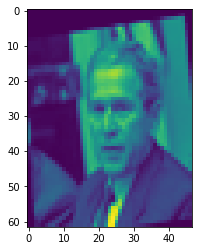

In [52]:
plt.imshow(X[0].reshape(62,47))

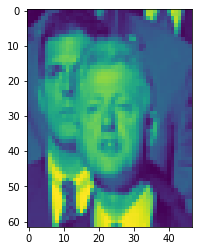

In [53]:
plt.imshow(X[-1].reshape(62,47))

In [ ]:
# I wont distribute the data as train and test since we don't have too much data and the purpose of following is just show case.

In [55]:
y_scores = mod.cross_val_predict(tree.DecisionTreeClassifier(random_state = 42), X,y,cv=3,method = "predict_proba")[:,1]

In [56]:
fpr,tpr,thresholds = met.roc_curve(y,y_scores)

Classical: 0.667957059206246


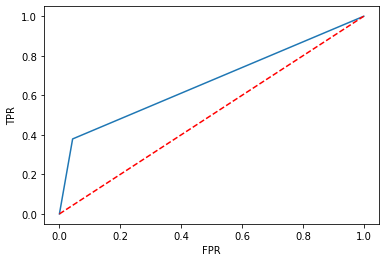

In [57]:
print("Classical:", met.roc_auc_score(y,y_scores))
plt.plot(fpr,tpr,label = "classical")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0,1],[0,1],"r--")

c_weight:balanced 0.6899154196486662
c_weight:{0: 1, 1: 10} 0.6353610930383865


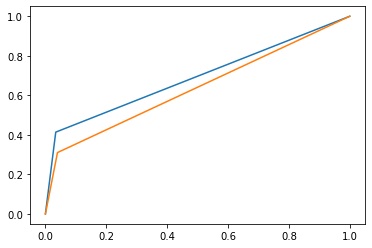

In [58]:
for w in ["balanced",{0:1,1:10}]:
     y_scores = mod.cross_val_predict(tree.DecisionTreeClassifier(random_state = 42,class_weight = w), X,y,cv=3,method = "predict_proba")[:,1]

     fpr,tpr,thresholds = met.roc_curve(y,y_scores)
    
     print("c_weight:" + str(w), met.roc_auc_score(y,y_scores))
     plt.plot(fpr,tpr,label = "c_weight" + str(w))

RandomUnderSampler0.25 0.6831489915419648
SMOTE0.25 0.6278139232270658
TomekLinks0.25 0.667957059206246
SMOTEENN0.25 0.7823031880286272
RandomUnderSampler0.4 0.671665582303188
SMOTE0.4 0.686402081977879
TomekLinks0.4 0.667957059206246
SMOTEENN0.4 0.6876057254391672


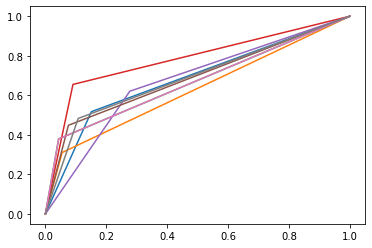

In [64]:
for ratio in [0.25,0.4]:
     estimators = [und.RandomUnderSampler(sampling_strategy = ratio,random_state = 42),
                   over.SMOTE(sampling_strategy = ratio,random_state = 42,k_neighbors = 5),
                   und.TomekLinks(),
                   com.SMOTEENN(sampling_strategy = ratio,random_state = 42)]
    
     for est in estimators:
         pipe_dct = imb.Pipeline([
             ("est", est),
             ("dct",tree.DecisionTreeClassifier(random_state = 42))
             ])
        
         y_scores = mod.cross_val_predict(pipe_dct, X,y,cv=3,method = "predict_proba")[:,1]
        
         fpr,tpr,thresholds = met.roc_curve(y,y_scores)
        
         print(est.__class__.__name__ + str(ratio), met.roc_auc_score(y,y_scores))
         plt.plot(fpr,tpr,label = est.__class__.__name__ + str(ratio))